In [1]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from pyro.nn import DenseNN
from pyro.distributions.transforms import AffineCoupling

from vaemcmc.models.encoders import EncoderMLP
from vaemcmc.models.decoders import DecoderMLP
from vaemcmc.vae import VAE, VAETarget
from vaemcmc.mcmc import ISIRKernel
from vaemcmc.dataset import SyntheticDataset
from vaemcmc.trainer import Trainer
from vaemcmc.distributions.likelihood import NormalLikelihood
from vaemcmc.viz.synthetic import plot_kde, plot_chain, scatter
from vaemcmc.models.rnvp import RNVP, FlowML

from vaemcmc.distributions.synthetic import Banana

/Users/evgeny/miniconda3/envs/vaemcmc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
AMB_DIM = 256
LAT_DIM = 16
HIDDEN_DIM = 32
NUM_BLOCKS = 2


sigma_b = 5.0
banana_b = 0.02

xlim = (-15, 15)
ylim = (-4, 4)

PROJ = (AMB_DIM - 2, AMB_DIM - 1)

target = Banana(AMB_DIM, banana_b, sigma_b)

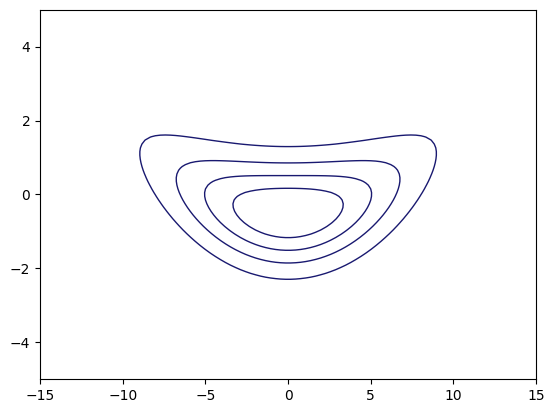

In [3]:
ax = plt.subplot()
target.plot_2d_contour(ax)
# ax.axis('auto')

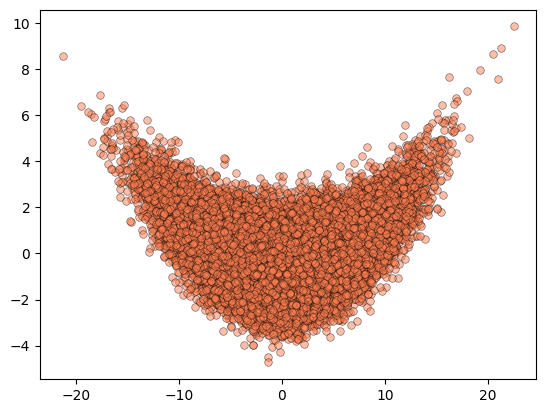

In [4]:
true_sample = target.sample((500 * 100,))
scatter(true_sample[..., PROJ]);

In [5]:

# train_dataset = TensorDataset(target.sample(1000))
train_dataset = SyntheticDataset(target.sample((10000,)))
train_dataloader = DataLoader(train_dataset, batch_size=16)

val_dataset = SyntheticDataset(target.sample((10000,)))
val_dataloader = DataLoader(val_dataset, batch_size=16)

encoder = EncoderMLP(AMB_DIM, 2 * LAT_DIM, HIDDEN_DIM, n_layers=NUM_BLOCKS)
decoder = DecoderMLP(LAT_DIM, AMB_DIM, HIDDEN_DIM, n_layers=NUM_BLOCKS)

sigma = 1.
likelihood = NormalLikelihood(sigma)
vae = VAE(encoder, decoder, likelihood)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

logging.basicConfig(format='%(asctime)s [%(levelname)-8s] %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
    
trainer = Trainer(vae, optimizer, train_dataloader, val_dataloader=val_dataloader, logger=logger)


In [6]:
trainer.train(20)

2023-05-30 11:05:18,573 [INFO    ] 5%|5         | 1/20 [00:01<00:29,  1.53s/it]
2023-05-30 11:05:19,363 [INFO    ] Loss: 1810.9249267578125
2023-05-30 11:05:21,468 [INFO    ] 15%|#5        | 3/20 [00:04<00:25,  1.48s/it]
2023-05-30 11:05:21,721 [INFO    ] Loss: 1754.2435302734375
2023-05-30 11:05:22,755 [INFO    ] 20%|##        | 4/20 [00:05<00:22,  1.40s/it]
2023-05-30 11:05:23,620 [INFO    ] Loss: 1865.60791015625
2023-05-30 11:05:25,034 [INFO    ] 30%|###       | 6/20 [00:07<00:17,  1.26s/it]
2023-05-30 11:05:25,454 [INFO    ] Loss: 1692.224609375
2023-05-30 11:05:26,137 [INFO    ] 35%|###5      | 7/20 [00:09<00:15,  1.21s/it]
2023-05-30 11:05:27,087 [INFO    ] Loss: 1747.503173828125
2023-05-30 11:05:28,065 [INFO    ] 45%|####5     | 9/20 [00:11<00:11,  1.08s/it]
2023-05-30 11:05:28,631 [INFO    ] Loss: 1763.4444580078125
2023-05-30 11:05:30,025 [INFO    ] 55%|#####5    | 11/20 [00:12<00:09,  1.03s/it]
2023-05-30 11:05:30,235 [INFO    ] Loss: 1737.3406982421875
2023-05-30 11:05:31,

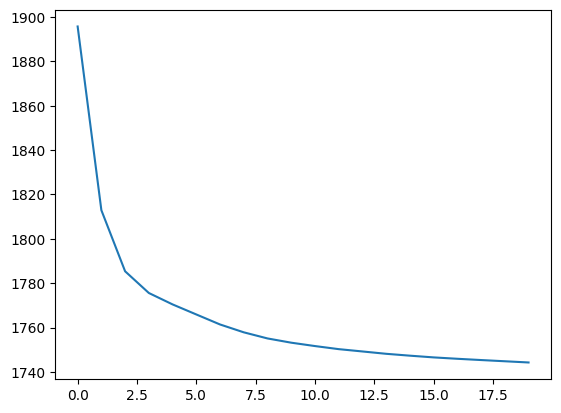

In [7]:
plt.plot(trainer.training_stats['epoch_loss'])

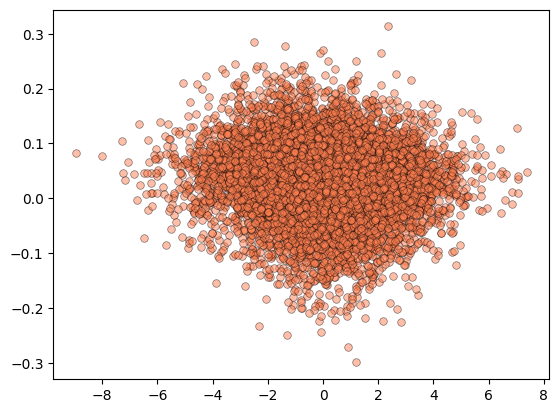

In [8]:
vae_sample = vae.sample((10000,)).detach().cpu()

scatter(vae_sample[..., PROJ]);

(-4.0, 4.0)

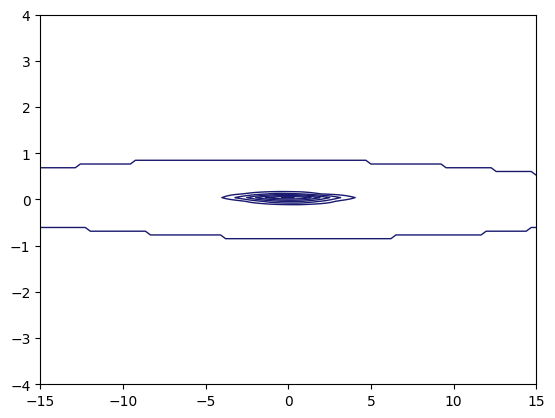

In [9]:
sample = vae.sample((20000,)).detach().cpu()
fig = plot_kde(sample[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')

In [10]:
z_start = vae.prior.sample((100,))

target_vae = VAETarget(vae, target)
proposal = vae.prior
isir_kernel = ISIRKernel(target_vae, proposal=proposal, n_particles=25)

In [11]:
vae_z_chain = isir_kernel.run(z_start, 500, 500)

In [12]:
x_start = vae.decode(z_start).detach().cpu()
vae_x_chain = vae.decode(vae_z_chain).detach().cpu()

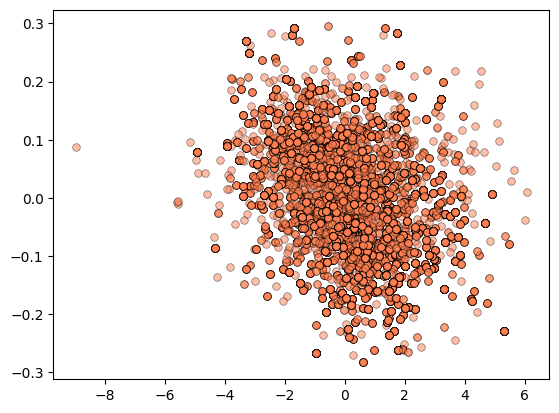

In [13]:
scatter(vae_x_chain[..., PROJ].view(-1, 2));

(-4.0, 4.0)

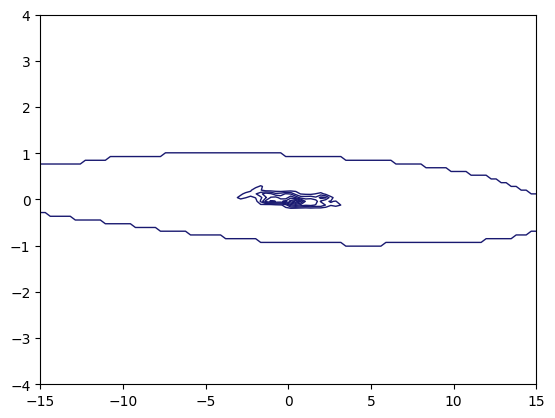

In [14]:
fig = plot_kde(vae_x_chain[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


(-4.0, 4.0)

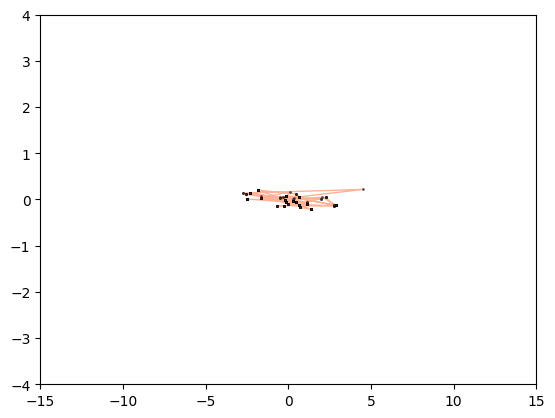

In [15]:
fig = plot_chain(vae_x_chain[:, 0, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


In [16]:
split_dim = max(AMB_DIM - HIDDEN_DIM, AMB_DIM // 2)
flows = [
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [HIDDEN_DIM],
            [AMB_DIM - split_dim, AMB_DIM - split_dim],
        ),
    )
    for _ in range(NUM_BLOCKS - 1)
]
split_dim = max(AMB_DIM - HIDDEN_DIM, AMB_DIM // 2)
flows.append(
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [HIDDEN_DIM],
            [AMB_DIM - split_dim, AMB_DIM - split_dim],
        ),
    )
)

rnvp = RNVP(flows=flows, dim=AMB_DIM)
rnvp_ml = FlowML(rnvp)
optimizer = torch.optim.Adam(rnvp_ml.parameters(), lr=3e-4)
trainer = Trainer(rnvp_ml, optimizer, train_dataloader, val_dataloader)

In [17]:
trainer.train(10)

2023-05-30 11:05:52,917 [INFO    ] 10%|#         | 1/10 [00:01<00:12,  1.37s/it]
2023-05-30 11:05:53,716 [INFO    ] Loss: 1597.06982421875
2023-05-30 11:05:55,603 [INFO    ] 30%|###       | 3/10 [00:04<00:09,  1.35s/it]
2023-05-30 11:05:55,872 [INFO    ] Loss: 1565.277587890625
2023-05-30 11:05:56,968 [INFO    ] 40%|####      | 4/10 [00:05<00:08,  1.36s/it]
2023-05-30 11:05:58,045 [INFO    ] Loss: 1646.4271240234375
2023-05-30 11:05:59,794 [INFO    ] 60%|######    | 6/10 [00:08<00:05,  1.40s/it]
2023-05-30 11:06:00,326 [INFO    ] Loss: 1559.1531982421875
2023-05-30 11:06:01,142 [INFO    ] 70%|#######   | 7/10 [00:09<00:04,  1.38s/it]
2023-05-30 11:06:02,486 [INFO    ] Loss: 1590.37255859375
2023-05-30 11:06:03,894 [INFO    ] 90%|######### | 9/10 [00:12<00:01,  1.38s/it]
2023-05-30 11:06:04,756 [INFO    ] Loss: 1591.3013916015625
2023-05-30 11:06:05,336 [INFO    ] 100%|##########| 10/10 [00:13<00:00,  1.38s/it]


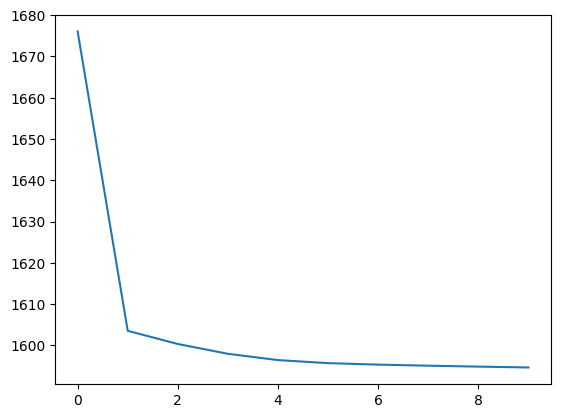

In [18]:
plt.plot(trainer.training_stats['epoch_loss'])

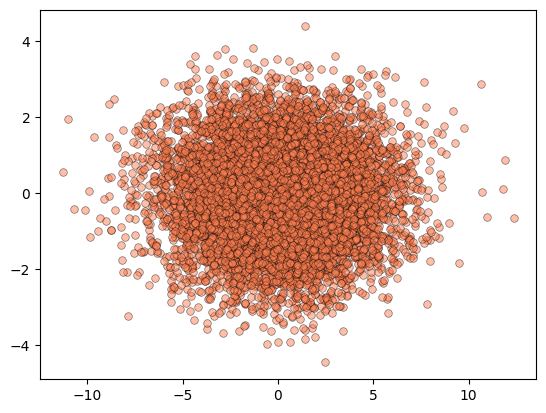

In [19]:
rnvp_sample = rnvp.sample((10000,)).detach().cpu()

scatter(rnvp_sample[:, PROJ]);

(-4.0, 4.0)

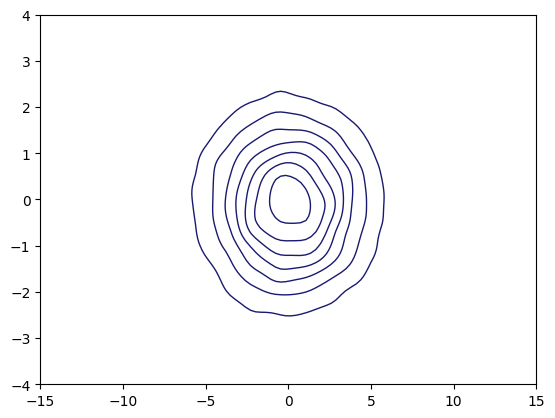

In [20]:
sample = rnvp.sample((20000,)).detach().cpu()
fig = plot_kde(sample[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


In [21]:
proposal = rnvp
isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=25)

In [22]:
z_start = rnvp.sample((100,))
rnvp_x_chain = isir_kernel.run(z_start, 500, 500)

In [23]:
# x_start = flow.inverse(z_start)[0].detach().cpu()
# x_chain = flow.inverse(chain)[0].detach().cpu()
x_start = z_start.detach().cpu()
rnvp_x_chain = rnvp_x_chain.detach().cpu()

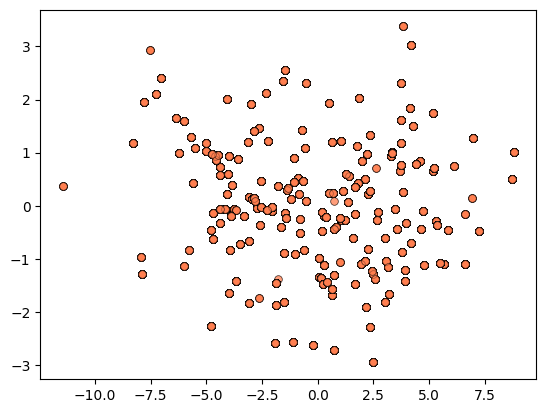

In [24]:
scatter(rnvp_x_chain[..., PROJ].view(-1, 2));


(-4.0, 4.0)

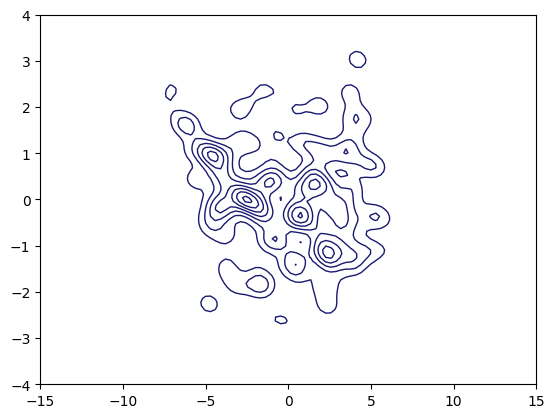

In [25]:
fig = plot_kde(rnvp_x_chain[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


(-4.0, 4.0)

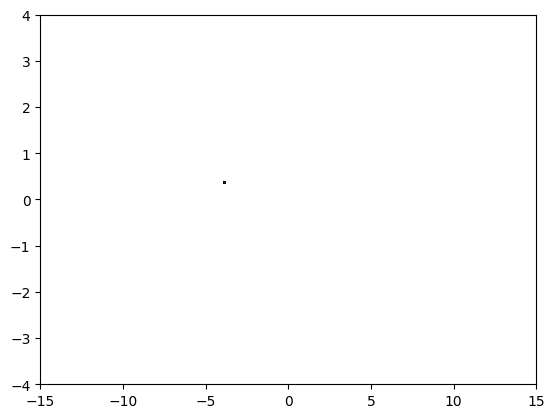

In [26]:
fig = plot_chain(rnvp_x_chain[:, 0, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


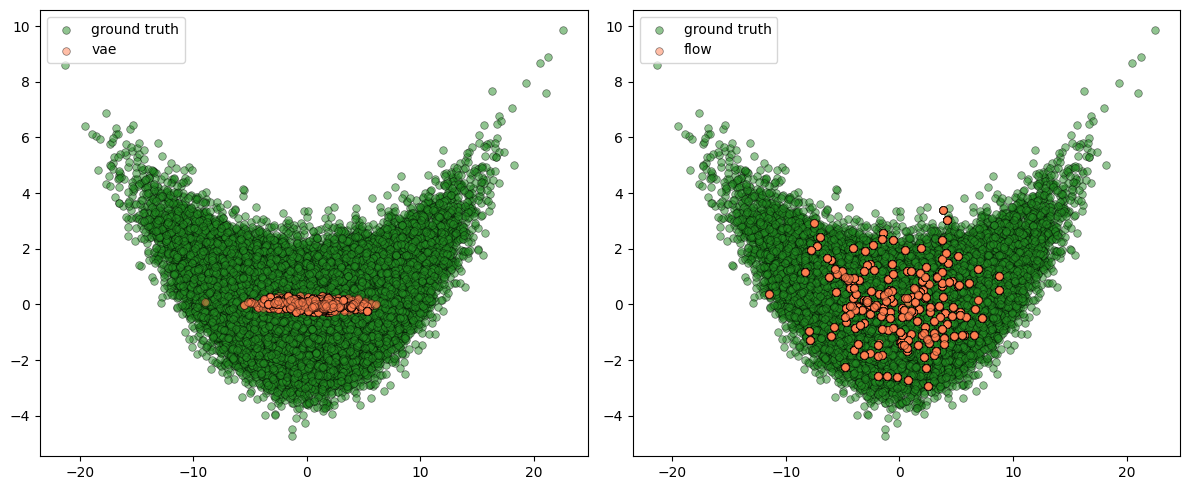

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

scatter(true_sample[..., PROJ], c='forestgreen', ax=axs[0], label='ground truth')
scatter(vae_x_chain[..., PROJ].view(-1, 2), ax=axs[0], label='vae')

scatter(true_sample[..., PROJ], c='forestgreen', ax=axs[1], label='ground truth')
scatter(rnvp_x_chain[..., PROJ].view(-1, 2), ax=axs[1], label='rnvp')

fig.tight_layout()
for ax in axs:
    ax.legend()
plt.savefig('../figs/vae_rnvp_banana.png')